In [11]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt     
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence 

from window_data import *

import os, errno
import sys
from tqdm import trange

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

## Get Data

In [2]:
breath_df = pd.read_pickle('breath_pickle')
under2 = breath_df[abs(breath_df['Csv_breath_holds']-breath_df['Data_breath_holds'])<=2]

In [3]:
# Use subset of data for now
under2 = under2[0:500]

## Create Windowed Data

In [4]:
num_outputs=50

In [5]:
df = create_windowed_data(n_steps=150, num_outputs=num_outputs, dataset=under2['Trace'])

In [6]:
df.head()

,Trace,Next_pts,Trace_num
0,"[0.0003, 0.0006, 0.001, 0.0014, 0.0019, 0.0023...","[0.5461, 0.55, 0.5538, 0.5575, 0.5612, 0.5649,...",0
1,"[0.7072, 0.7096, 0.7119, 0.714, 0.716, 0.7177,...","[0.4166, 0.4121, 0.4076, 0.4031, 0.3986, 0.394...",0
2,"[0.2135, 0.2098, 0.2061, 0.2025, 0.1988, 0.195...","[-0.0445, -0.0449, -0.0453, -0.0457, -0.0461, ...",0
3,"[-0.0129, -0.0113, -0.0096, -0.0077, -0.0057, ...","[0.6138, 0.6173, 0.6208, 0.6243, 0.6277, 0.631...",0
4,"[0.7595, 0.7619, 0.7642, 0.7665, 0.7686, 0.770...","[0.5701, 0.5656, 0.5612, 0.5567, 0.5522, 0.547...",0


## Train Val Test Split

In [9]:
df['Trace_num'].unique()

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [10]:
train = df[df['Trace_num']>=51]
valid = df[(df['Trace_num']>=40) & (df['Trace_num']<51)]
test = df[df['Trace_num']<40]

In [11]:
X_train = train['Trace']
y_train = train['Next_pts']

X_val = valid['Trace']
y_val = valid['Next_pts']

X_test = test['Trace']
y_test = test['Next_pts']

## Scale Data

In [12]:
scaler = StandardScaler()
# Fit
scaler.fit(list(X_train))
# Transform
x_train = scaler.transform(list(X_train))
x_val = scaler.transform(list(X_val))
x_test = scaler.transform(list(X_test))

In [13]:
print(x_train.shape, x_val.shape, x_test.shape)

(1603, 150) (408, 150) (1165, 150)


##  Reshape Data

In [14]:
def reshape_trace(trace):
    trace = np.transpose(trace)
    return trace.reshape(trace.shape[0],trace.shape[1], 1)

In [15]:
x_train = reshape_trace(x_train)
x_val = reshape_trace(x_val)
x_test = reshape_trace(x_test)

In [16]:
print(x_train.shape, x_val.shape, x_test.shape)

(150, 1603, 1) (150, 408, 1) (150, 1165, 1)


In [17]:
y_train2 = reshape_trace(list(y_train))
y_val2 = reshape_trace(list(y_val))
y_test2 = reshape_trace(list(y_test))

## Define Dataset

In [18]:
#dataset
from torch.utils.data import Dataset

In [19]:
class timeseries(Dataset):
    def __init__(self,x,y):
        self.x = torch.tensor(x,dtype=torch.float32)
        self.y = torch.tensor(y,dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self,idx):
        return self.x[idx],self.y[idx]
  
    def __len__(self):
        return self.len

In [20]:
dataset = timeseries(x_train,y_train2)
test_dataset = timeseries(x_val,y_val2)
final_test_dataset = timeseries(x_test,y_val2)

In [21]:
dataset.x.shape

torch.Size([150, 1603, 1])

In [22]:
train_loader = DataLoader(dataset,shuffle=False,batch_size=200)
test_loader = DataLoader(test_dataset,shuffle=False,batch_size=200)

## Define LSTM Encoder and Decoder (Multistep Prediction)

In [23]:
# neural network
from torch import nn

class lstm_encoder(nn.Module):
    ''' Encodes a time series sequence '''
    
    def __init__(self, input_size=1, hidden_size=5, num_layers=1):

        super(lstm_encoder, self).__init__()
        self.input_size = input_size # the number of features in the input X
        self.hidden_size = hidden_size # the number of features in the hidden state h
        self.num_layers = num_layers # number of recurrent layers 
        
        # define an LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers)
        
    def forward(self, x):
        output, self.hidden = self.lstm(x.view(x.shape[0], x.shape[1], self.input_size))
        
        return output, self.hidden   # hidden gives the hidden state and cell state for the last element in the sequence 
                                     # give this to decoder
    
    def init_hidden(self, batch_size):
        return (torch.zeros(self.num_layers, batch_size, self.hidden_size),
                torch.zeros(self.num_layers, batch_size, self.hidden_size))
    
        

In [24]:
class lstm_decoder(nn.Module):
    ''' Decodes hidden state output by encoder '''
    
    def __init__(self, input_size=1, hidden_size=5, num_layers=1):

        super(lstm_decoder, self).__init__()
        self.input_size = input_size   # the number of features in the input X
        self.hidden_size = hidden_size # the number of features in the hidden state h
        self.num_layers = num_layers   # number of recurrent layers

        # Define LSTM layer and Linear layer
        self.lstm = nn.LSTM(input_size = input_size, hidden_size = hidden_size,
                            num_layers = num_layers)
        self.linear = nn.Linear(hidden_size, input_size)       
    
    
    def forward(self, x, encoder_hidden_states):
        output, self.hidden = self.lstm(x.unsqueeze(0), encoder_hidden_states)
        output = self.linear(output.squeeze(0))     
        
        return output, self.hidden


## Define Model

In [25]:
class lstm_seq2seq(nn.Module):
    ''' train LSTM encoder-decoder and make predictions '''
    
    def __init__(self, input_size=1, hidden_size=5):

        super(lstm_seq2seq, self).__init__()

        self.input_size = input_size   # number of expected features in the input X
        self.hidden_size = hidden_size # number of features in the hidden state h
        
        # Encoder and decoder
        self.encoder = lstm_encoder(input_size=input_size, hidden_size=hidden_size)
        self.decoder = lstm_decoder(input_size=input_size, hidden_size=hidden_size)
        
    
    def train_model(self, input_tensor, target_tensor, n_epochs, target_len,batch_size,learning_rate = 0.01):
        losses = np.full(n_epochs, np.nan)

        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        criterion = nn.MSELoss()

        # calculate number of batch iteraations
        n_batches = int(input_tensor.shape[1] / batch_size)

        with trange(n_epochs) as tr:
            for it in tr:
                batch_loss = 0.
  
                for b in range(n_batches):
                    # select data 
                    input_batch = input_tensor[:, b: b + batch_size, :]
                    target_batch = target_tensor[:, b: b + batch_size, :]

                    # outputs tensor
                    outputs = torch.zeros(target_len, batch_size, input_batch.shape[2])

                    # initialize hidden state
                    encoder_hidden = self.encoder.init_hidden(batch_size)

                    # zero the gradient
                    optimizer.zero_grad()

                    # encoder outputs
                    encoder_output, encoder_hidden = self.encoder(input_batch)

                    # decoder with teacher forcing
                    decoder_input = input_batch[-1, :, :]   # shape: (batch_size, input_size)
                    decoder_hidden = encoder_hidden

                    for t in range(target_len): 
                        decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
                        outputs[t] = decoder_output
                        decoder_input = decoder_output

                    # compute the loss 
                    loss = criterion(outputs, target_batch)
                    batch_loss += loss.item()

                    # backpropagation
                    loss.backward()
                    optimizer.step()

                # loss for epoch 
                batch_loss /= n_batches 
                losses[it] = batch_loss

                # progress bar 
                tr.set_postfix(loss="{0:.3f}".format(batch_loss))

        return losses

        
    def predict(self, input_tensor, target_len):
        
        # encode input_tensor
        input_tensor = input_tensor.unsqueeze(1)     # add in batch size of 1
        encoder_output, encoder_hidden = self.encoder(input_tensor)

        # initialize tensor for predictions
        outputs = torch.zeros(target_len, input_tensor.shape[2])

        # decode input_tensor
        decoder_input = input_tensor[-1, :, :]
        decoder_hidden = encoder_hidden
        
        for t in range(target_len):
            decoder_output, decoder_hidden = self.decoder(decoder_input, decoder_hidden)
            outputs[t] = decoder_output.squeeze(0)
            decoder_input = decoder_output
            
        np_outputs = outputs.detach().numpy()
        
        return np_outputs


## Train a model

In [28]:
mymodel = lstm_seq2seq(input_size=1, hidden_size=5)
print(f'Model Details - Hidden Size {5} \t Learning Rate: {0.001}')
train_loss = mymodel.train_model(dataset.x, dataset.y, n_epochs = 100, target_len = num_outputs, batch_size = 200, learning_rate = 0.001)


Model Details - Hidden Size 5 	 Learning Rate: 0.001


100%|██████████| 100/100 [00:26<00:00,  3.80it/s, loss=0.067]


In [30]:
train_loss2 = mymodel.train_model(dataset.x, dataset.y, n_epochs = 15, target_len = num_outputs, batch_size = 200, learning_rate = 0.001)

100%|██████████| 15/15 [00:03<00:00,  3.83it/s, loss=0.062]


In [31]:
modname = 'lstm_encode_decode_' + '50'
torch.save(mymodel, modname)

In [44]:
mod = lstm_seq2seq(input_size=1, hidden_size=5)
mod = torch.load('lstm_encode_decode_50')

## Plots

In [45]:
test_preds = gather_preds(mod, final_test_dataset, num_outputs)
valid_preds = gather_preds(mod, test_dataset, num_outputs)
train_preds = gather_preds(mod, dataset, num_outputs)

In [46]:
train['preds'] = train_preds
valid['preds'] = valid_preds
test['preds'] = test_preds

In [47]:
train.to_pickle("train_df_50.pkl")  
valid.to_pickle("valid_df_50.pkl")  
test.to_pickle("test_df_50.pkl")  

In [8]:
train = pd.read_pickle("train_df_50.pkl") 
valid = pd.read_pickle("valid_df_50.pkl")  
test = pd.read_pickle("test_df_50.pkl")  

In [9]:
train_full_traces = train.groupby('Trace_num')['Next_pts'].apply(list)
valid_full_traces = valid.groupby('Trace_num')['Next_pts'].apply(list)
test_full_traces = test.groupby('Trace_num')['Next_pts'].apply(list)

In [10]:
train_pred_trace = train.groupby('Trace_num')['preds'].apply(list)
valid_pred_trace = valid.groupby('Trace_num')['preds'].apply(list)
test_pred_trace = test.groupby('Trace_num')['preds'].apply(list)

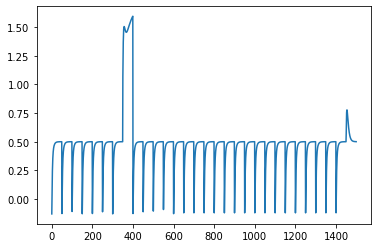

In [13]:
plot_preds(test_pred_trace[0])

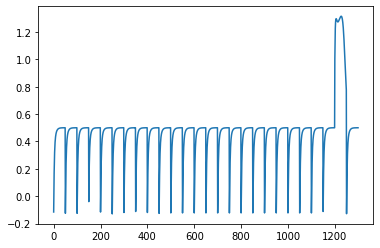

In [16]:
plot_preds(test_pred_trace[10])

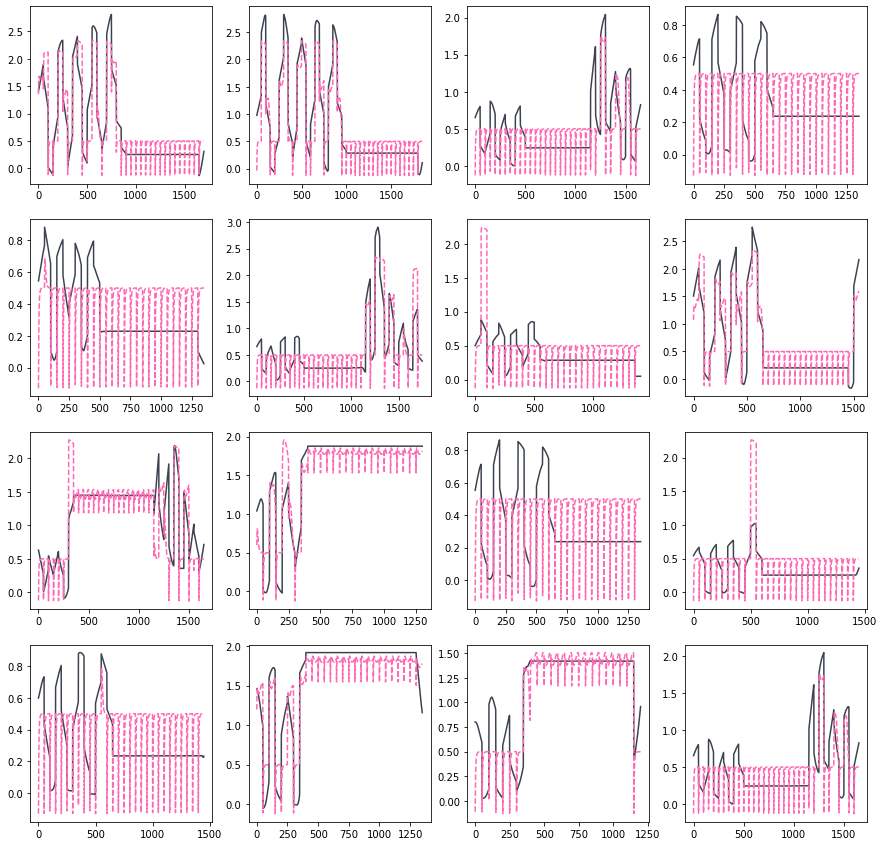

In [92]:
reconstruct_trace(test_full_traces, test_pred_trace)